In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/morph/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [17]:
import jax.numpy as np
from jax import vmap

import equinox as eqx
import optax
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import poppy

---
# Base Classes

In [3]:
# Base Classes
class Layer(eqx.Module):
    """
    Base Layer class
    Can optionally pass in 'function' in order to facilitate parameterised planes
    Can optionally pass in 'static' to automatically freeze in the parameters
    """
    size_in: int = eqx.static_field()
    size_out: int = eqx.static_field()
    
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out

class OpticalSystem(eqx.Module):
    """
    Base class defining some optical system
    layers must be a list of Layer objects
    Each layer object can either be some optical operation, 
    transform, or NN type layer
    """
    layers: list 
    
    def __init__(self, layers):
        self.layers = layers 
        
    def __call__(self, wavel):
        wavefront = self.layers[0](wavel) # Always assumed to be CreateWavefront layer
        for i in range(1, len(self.layers)):
            wavefront = self.layers[i](wavefront, wavel)
        return np.abs(wavefront)**2

---

## Layer Sub-Classes

In [11]:
class CreateWavefront(Layer):
    """
    Initialises an input wavefront
    x and y should be in radians (measured from the optical axis)
        How to pass in aperture to this robustly? As a property of the osys?
        What if we want to optimise the aperture size? 
        Shuould this exist outside of the system?
        Always propagate on axis and and shift with the offset term in MFT?
    To Do: Test this properly
    """
    x: float
    y: float
    aperture: float
    
    def __init__(self, size):
        """
        Defaults the aperture size to 1
        """
        self.size_in = size
        self.size_out = size
        self.x = 0.
        self.y = 0.
        self.aperture = 0
    
    def __call__(self, wavel):
        """
        x and y are assumed to be in radiands deivation from the optical
        axis
        aperture is assumed to be in meters
        """

        npix = self.size_in
        x, y = self.x, self.y
        aperture = self.aperture

        rmax = np.hypot(x, y)
        phi_rot = np.arctan2(y, x)
        opd_max = aperture * np.sin(rmax)
        phase_max = opd_to_phase(opd_max, wavel)

        # Figure out which one of these is right
        phase_slope = np.linspace(0, phase_max, npix, endpoint=False)
        phase_array = np.tile(phase_slope, [npix, 1])

        xs = np.linspace(0, np.pi/4, npix, endpoint=False)
        XX, YY = np.meshgrid(xs, xs)
        RR = np.hypot(XX, YY)
        PHI = np.arctan2(YY, XX) - phi_rot
        phase_out = rmax * RR * np.sin(PHI)
        wavefront_out = np.ones([npix, npix]) * np.exp(1j * phase_out)

        return wavefront_out
    
class MultiplyArray(Layer):
    """
    Multiplies the input wavefront by an array
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, array, dummy_wavel):
        return np.multiply(array, self.array)
    
class NormaliseWavefront(Layer):
    """
    Normalises the input wavefront
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, wavefront, dummy_wavel):
        norm_factor = np.sqrt(np.sum(np.abs(wavefront)**2))
        norm_wavefront = wavefront/norm_factor
        return norm_wavefront
    
class MFT(Layer):
    """
    Matches poppy but assumes square
    """
    wavel_scale: float = eqx.static_field()    
    
    def __init__(self, size_in, size_out, wavel_scale):
        self.size_in = size_in
        self.size_out = size_out
        self.wavel_scale = wavel_scale
        
    def __call__(self, wavefront, wavel):
        """
        Should we add offset here too?
        I have removed it but we have the code needed in the old notebooks
        """
        npup, npix = self.size_in, self.size_out
        nlamD = self.wavel_scale / wavel
        
        dX = 1.0 / float(npup)
        dU = nlamD / float(npix)
        Xs = (np.arange(npup, dtype=float) - float(npup) / 2.0 + 0.5) * dX
        Us = (np.arange(npix, dtype=float) - float(npix) / 2.0 + 0.5) * dU
        XU = np.outer(Xs, Us)
        expXU = np.exp(-2.0 * np.pi * 1j * XU)

        # Note: Can casue overflow issues on 32-bit
        norm_coeff = np.sqrt((nlamD**2) / (npup**2 * npix**2)) 

        # Perform MFT
        t1 = np.dot(expXU.T, wavefront)
        t2 = np.dot(t1, expXU)
        return norm_coeff * t2
    
class ApplyZernike(Layer):
    """
    Adds an array of phase values to the input wavefront calculated from the OPD
    """
    nterms: int = eqx.static_field()
    basis: jax.numpy.ndarray = eqx.static_field()
    coefficients: jax.numpy.ndarray
    
    def __init__(self, size, nterms, coefficients):
        self.size_in = size
        self.size_out = size
        self.nterms = nterms
        self.coefficients = coefficients
        # Load basis
        self.basis = np.array(np.nan_to_num(
            poppy.zernike.zernike_basis(nterms=nterms+3, npix=size)[3:])).T
        print("Note Zernike Ignores Piston Tip Tilt")
        
    def __call__(self, complex_array, wavel):
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array)
        zernike_opd = np.dot(self.basis, self.coefficients)
        zernike_phase = self._opd_to_phase(zernike_opd, wavel)
        phase_out = phase + zernike_phase
        return amplitude * np.exp(1j*phase_out)
    
    def _opd_to_phase(self, opd, wavel):
        return 2*np.pi*opd/wavel
    
    def get_total_opd(self):
        return np.dot(self.basis, self.coefficients)

--- 

## Functions

In [12]:
# Helper functions
def create_aperture_asym(npix):
    # Create aperture
    xs = np.arange(-npix//2, npix//2)
    XX, YY = np.meshgrid(xs, xs)
    RR = np.hypot(XX, YY)
    aperture = RR < npix//2
    
    c = npix//2
    s = c//3
    aperture = aperture.at[c-s:c+s, :c].set(0)
    return aperture

def opd_to_phase(opd, wavel):
    return 2*np.pi*opd/wavel

def phase_to_opd(phase, wavel):
    return (phase * wavel)/(2*np.pi)

---

### Osys creation

Define some osys by a list of layers

In [13]:
npix = 512
aperture = create_aperture_asym(npix)
wavel_scale = 1.5e-4

In [14]:
min_wavel = 5.45e-6
max_wavel = 6.45e-6
mean_wavel = (max_wavel + min_wavel)/2
nwavels = 5
wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [15]:
# Zernikes
nterms = 7 #12
onp.random.seed(0)
coeffs_true = 0.4*mean_wavel*np.array(onp.random.rand(nterms)-0.5)

In [18]:
# Target Model
layers = [CreateWavefront(npix),                               # Wavefront creation
          MultiplyArray(npix, aperture),                       # Apply aperture
          NormaliseWavefront(npix),                            # Normalise input power
          ApplyZernike(npix, nterms, coeffs_true),             # Apply Phase Screen
          MFT(npix, npix, wavel_scale)]                        # Tranform to focal plane

# Optimisation Model
layers_init = [CreateWavefront(npix),                          # Wavefront creation
               MultiplyArray(npix, aperture),                  # Apply aperture
               NormaliseWavefront(npix),                       # Normalise input power
               ApplyZernike(npix, nterms, np.zeros([nterms])), # Apply Phase Screen
               MFT(npix, npix, wavel_scale)]                   # Tranform to focal plane

Note Zernike Ignores Piston Tip Tilt
Note Zernike Ignores Piston Tip Tilt


In [19]:
ideal_model = OpticalSystem(layers)
model = OpticalSystem(layers_init)

In [20]:
data = vmap(ideal_model)(wavels).sum(0)
initial_psf = vmap(model)(wavels).sum(0)

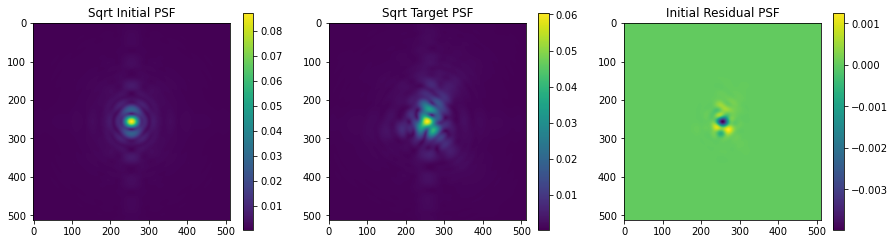

In [21]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Sqrt Initial PSF")
plt.imshow(initial_psf**0.5)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Sqrt Target PSF")
plt.imshow(data**0.5)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Initial Residual PSF")
plt.imshow(data-initial_psf)
plt.colorbar()
plt.show()

## Optimisaion

In [22]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def loss_func(model, wavels, data):
    psf = vmap(model)(wavels).sum(0)
    return np.sum((psf - data)**2)

In [23]:
model = OpticalSystem(layers_init)
optim = optax.adam(5e-9)
opt_state = optim.init(model)

errors, grads_out = [], []
for i in tqdm(range(2500)):
    loss, grads = loss_func(model, wavels, data)    
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    errors.append(loss)
    grads_out.append(grads)

  0%|          | 0/2500 [00:00<?, ?it/s]

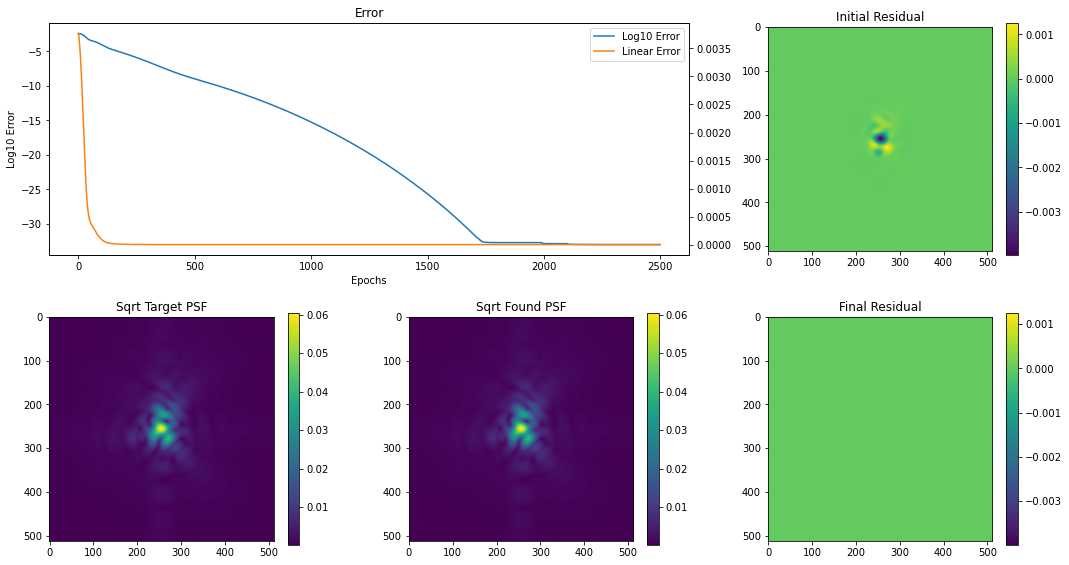

In [34]:
final_psf = vmap(model)(wavels).sum(0)
residual = data - final_psf
initial_residual = data - initial_psf

vmin = np.min(initial_residual)
vmax = np.max(initial_residual)

plt.figure(figsize=(15, 8))
ax = plt.subplot(2, 3, (1,2))
plt.title("Error")
plt.plot(np.arange(len(errors)), np.log10(np.array(errors)), label="Log10 Error")
plt.plot([], [], c='tab:orange', label="Linear Error")
plt.xlabel("Epochs")
plt.ylabel("Log10 Error")
plt.legend()
ax2 = ax.twinx()
ax2.plot(np.arange(len(errors)), np.array(errors), c='tab:orange')


plt.subplot(2, 3, 3)
plt.title("Initial Residual")
plt.imshow(initial_residual)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.title("Sqrt Target PSF")
plt.imshow(data**0.5)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Sqrt Found PSF")
im = plt.imshow(final_psf**0.5)
cbar = plt.colorbar(im)
plt.subplot(2, 3, 6)

plt.title("Final Residual")
plt.imshow(residual, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.tight_layout()
plt.show()

In [25]:
opd_in = ideal_model.layers[3].get_total_opd()
opd_out = model.layers[3].get_total_opd()
residual = opd_in - opd_out

RMSE_inital = opd_to_phase(np.sqrt(np.mean(opd_in**2)), mean_wavel)
RMSE_final  = opd_to_phase(np.sqrt(np.mean(residual**2)), mean_wavel)
print("Initial RMS Phase Error: {}".format(RMSE_inital))
print("Final RMS Phase Error:   {}".format(RMSE_final))

vmin = np.min(np.array([opd_in, opd_out]))
vmax = np.max(np.array([opd_in, opd_out]))

Initial RMS Phase Error: 0.6749456006282629
Final RMS Phase Error:   9.647273892892622e-16


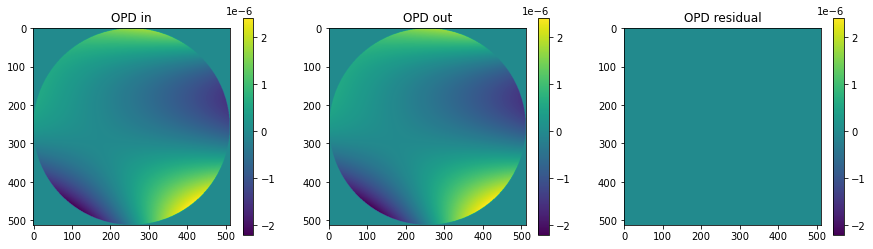

In [26]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("OPD in")
plt.imshow(opd_in, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(opd_out, vmin=vmin, vmax=vmax)
plt.title("OPD out")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(residual, vmin=vmin, vmax=vmax)
plt.title("OPD residual")
plt.colorbar()
plt.show()

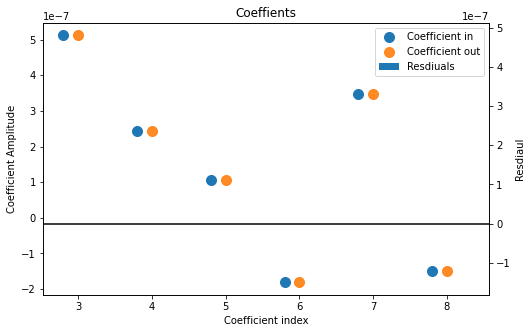

In [27]:
coeffs_out = model.layers[3].coefficients[1:]
coeffs_in = ideal_model.layers[3].coefficients[1:]
vmin = np.min(np.array([coeffs_out, coeffs_in]))
vmax = np.max(np.array([coeffs_out, coeffs_in]))
residual = coeffs_in - coeffs_out

plt.figure(figsize=(8, 5))
plt.title("Coeffients")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient Amplitude")

ax = plt.subplot(111)
ax.scatter(np.arange(nterms-1)+3-0.2, coeffs_in, s=100, label='Coefficient in')
ax.scatter(np.arange(nterms-1)+3   , coeffs_out, s=100, label='Coefficient out', alpha=0.9)
ax.bar([], [], alpha=0.8, width=0.2, label="Resdiuals")
ax.legend()

ax2 = ax.twinx()
ax2.set_ylabel("Resdiaul")
ax2.bar(np.arange(len(residual))+3+0.2, residual, width=0.2, alpha=0.8)#, c='tab:green')
ax2.set_ylim(vmin, vmax)
ax2.axhline(0, c='k')
plt.show()